In [41]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

In [42]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(15946)
df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'body_part_id', 'body_part_name',
       'sub_type_id', 'sub_type_name', 'x', 'y', 'pass_switch', 'outcome_id',
       'outcome_name', 'under_pressure', 'aerial_won', 'counterpress',
       'off_camera', 'ball_recovery_recovery_failure', 'pass_assisted_shot_id',
       'pass_shot_assist', 'shot_statsbomb_xg', 'end_z', 'shot_key_pass_id',
       'shot_first_time', 'technique_id', 'technique_name',
       'goalkeeper_position_id', 'goalkeeper_position_name', 'pass_cross',
       'block_deflection', 'dribble_

# Preparing the data

In [43]:
team = 'Barcelona'

#check for index of first sub
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == team].iloc[0]["index"]
#make df with successfull passes by the team until the first substitution
mask_team = (df.type_name == 'Pass') & (df.team_name == team) & (df.index < sub) & (df['x'] < df['end_x']) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
#taking necessary columns
df_pass = df.loc[mask_team, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
#adjusting that only the surname of a player is presented.
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

# Calculating vertices size and location

In [44]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

# Calculating edges width

In [45]:
#counting passes between players
# creates a new column called "pair_key" in the df_pass. 
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>0]

# Plotting vertices

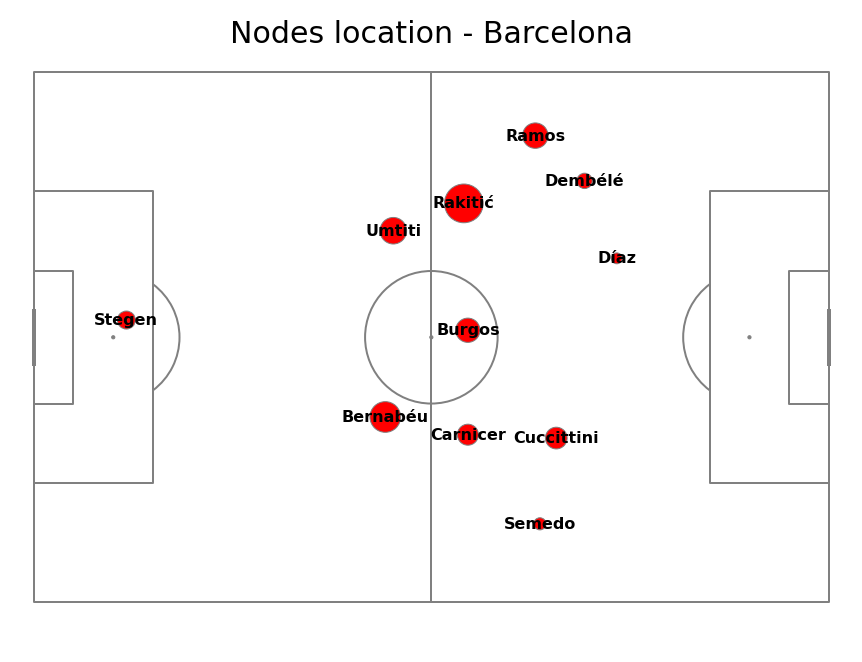

In [46]:
#Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
#annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle(f"Nodes location - {team}", fontsize = 30)
plt.show()

# Plotting edges

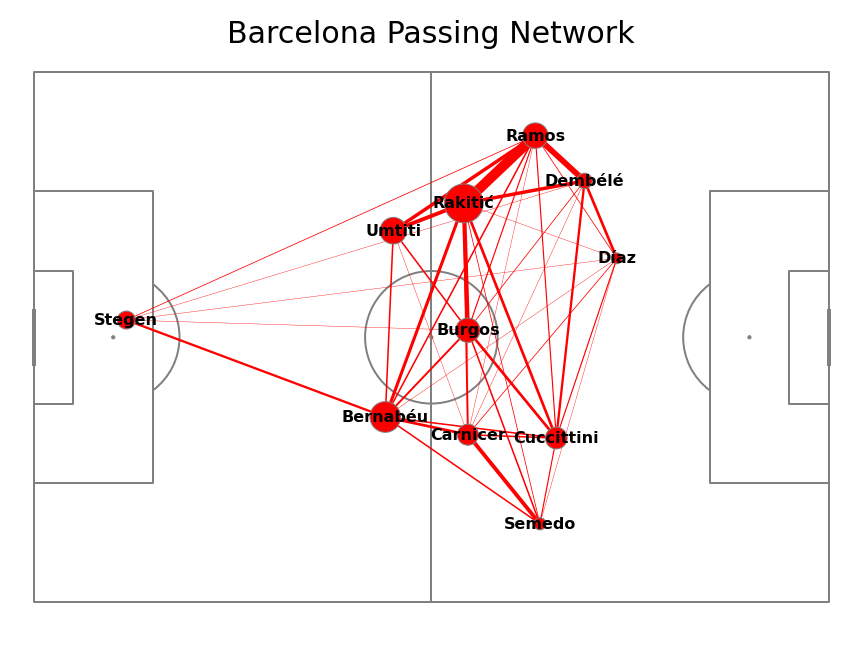

In [47]:
#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle(f"{team} Passing Network", fontsize = 30)
plt.show()
